In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """Generate class weights for imbalanced datasets.

  Args:
      class_series (list): List of class labels.
      multi_class (bool, optional): Defines if data is multiclass. Defaults to True.
      one_hot_encoded (bool, optional): Defines if data is one hot encoded. Defaults to False.

  Returns:
      dict: Dictionary of class weights and labels.
  """

  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)

    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

#Define a function to plot the loss per epoch 
def plot_loss(history):
    """Plot the loss per epoch.

    Args:
      history (any): History object.
    """
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['accuracy'], label="acc")
    plt.plot(history.history['val_accuracy'], label="val.acc")
    plt.xlabel('Epoch')
    plt.ylabel('Acc.')
    #Define the model again with the optimal params.

In [3]:
def save_network_structure(net, version):
    """ Save the network structure.

    Args:
        net (any): Network to save.
        version (string): Version of the network.
    """
    summary = net.summary()
    model_path = create_folder('../reports/'+version+"/train/")
    model_name = 'network_structure.png'
    plot_model(net, to_file=os.path.join(
        model_path, model_name), show_shapes=True)

    print(summary)


def create_folder(path):
    """ Create folder if it does not exist.

    Args:
        path (string): Path to create.

    Returns:
        string: Created path
    """

    new_path = os.path.join(path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return new_path

In [4]:
def load_data():
    """ Load training data and lables.

    Returns:
        list, list, list: Training data and class weights.
    """
    #Load colorplot datasets. 
    X = np.load('data.npz')['a'].reshape(5179, 200, 100, 1)

    #Creating the labels. 
    y = pd.read_excel('Labels_v1.xlsx', header = None).values

    #Shuffling the dataset.
    shuffler = np.random.permutation(len(y))
    X = X[shuffler]
    y = y[shuffler]
    class_weights = generate_class_weights(y[:,0])
    print(class_weights)
    print(np.unique(y[:,0]))
    
    return X, y, class_weights

In [13]:
def build_cnn(version):
        """ Build the CNN model.

        Args:
                version (string): Version of the network.

        Returns:
                any: Model.
        """
        net = Sequential()
        net.add(Conv2D(activation='relu', filters=32,
                kernel_size=(5, 5), input_shape=(200, 100, 1)))
        net.add(BatchNormalization())
        net.add(Conv2D(64, (3, 3), activation='relu'))
        net.add(MaxPool2D(pool_size=(2, 2)))
        net.add(BatchNormalization())
        net.add(Dropout(0.4))
        net.add(Conv2D(128, (3, 3), strides=2, activation='relu'))
        net.add(MaxPool2D(pool_size=(2, 2)))
        net.add(BatchNormalization())
        net.add(Dropout(0.4))
        net.add(Conv2D(256, (3, 3), activation='relu'))
        net.add(BatchNormalization())
        net.add(Dropout(0.4))
        net.add(Flatten())
#         net.add(GlobalAveragePooling2D())
        net.add(Dense(512, activation='relu'))
        net.add(Dropout(rate=0.5))
        net.add(Dense(1, activation='sigmoid'))

        save_network_structure(net, version)
        return net

In [17]:
def train(version):
    """ Train the model.

    Args:
        version (string): Version of the model.
    """

    # Define the K-fold Cross Validator
    X, y, class_weights = load_data()

    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # Define optimiser with a changed learning rate
    opt = tf.keras.optimizers.Adam(
        learning_rate=1e-05,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam",
    )

    inputs = X
    targets = np.asarray(y).astype('float32').reshape((-1, 1))
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        # Train the model
        
        # Save best model after each epoch
        model_path = create_folder('../models/'+version+"/")
        file_name = "version_"+version + \
            "_best_model_fold-" + str(fold_no) + ".h5"

        file_path = os.path.join(
            model_path, file_name)

        # Define early stopping callback
        es = [EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.01), tf.keras.callbacks.ModelCheckpoint(
            file_path,
            monitor="val_loss",
            verbose=1,
            save_best_only=True
        )]

        net = build_cnn(version)

        net.compile(loss='binary_crossentropy',
                    optimizer=opt, metrics="accuracy")

        history = net.fit(
            # changed expression for test features and labels
            inputs[train], targets[train],
            # I removed validation for k-fold cross validation
            validation_split=0.25,
            verbose=1, epochs=10000,
            class_weight=class_weights, callbacks=es)

        newfig = plt.figure()
        plot_loss(history)

        plt.show()
        # Prediction of the validation dataset
        test_predictions = net.predict(inputs[test]).flatten()
        fold_no = fold_no + 1

In [18]:
def test(filename):
    """ Test the model.

    Args:
        filename (string): Path of the model.
    """
    
    net = load_model(filename)
    labels_train = y
    
    outputs = net.predict(X)
    labels_predicted = np.argmax(outputs, axis=1)
    misclassified = sum(labels_predicted != labels_train)
    print('Percentage misclassified = ',
          100*misclassified/labels_train.size)
    print('Percentage misclassified = ',
          sum(100*misclassified/labels_train.size)/labels_train.size)

    plt.figure(figsize=(8, 2))
    for i in range(0, 8):
        ax = plt.subplot(2, 8, i+1)
        plt.imshow(X[i, :].reshape(200, 100), cmap=plt.get_cmap('gray_r'))
        plt.title(labels_train[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(0, 8):
        output = net.predict(X[i, :].reshape(1, 200, 100, 1))
        output = output[0, 0:]
        plt.subplot(2, 8, 8+i+1)
        plt.bar(np.arange(10.), output)
        plt.title(np.argmax(output))

    net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)
    plt.show()

{0: 0.5977608494921515, 1: 3.0572609208972845}
[0 1]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_24 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_25 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
 

2022-03-31 19:50:10.639748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.7309 - accuracy: 0.6958

2022-03-31 19:50:16.957995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.83612, saving model to ../models/2.0/version_2.0_best_model_fold-1.h5
98/98 [==============================] - 7s 71ms/step - loss: 0.7309 - accuracy: 0.6958 - val_loss: 1.8361 - val_accuracy: 0.1728
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7796
Epoch 00002: val_loss improved from 1.83612 to 1.71756, saving model to ../models/2.0/version_2.0_best_model_fold-1.h5
98/98 [==============================] - 7s 67ms/step - loss: 0.5282 - accuracy: 0.7799 - val_loss: 1.7176 - val_accuracy: 0.1728
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5050 - accuracy: 0.7967
Epoch 00003: val_loss improved from 1.71756 to 1.46363, saving model to ../models/2.0/version_2.0_best_model_fold-1.h5
98/98 [==============================] - 7s 68ms/step - loss: 0.5052 - accuracy: 0.7963 - val_loss: 1.4636 - val_accuracy: 0.1747
Epoch 4/10000
97/98 [============================>.] - ETA: 0s

Epoch 27/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9439
Epoch 00027: val_loss improved from 0.27906 to 0.27537, saving model to ../models/2.0/version_2.0_best_model_fold-1.h5
98/98 [==============================] - 7s 68ms/step - loss: 0.1554 - accuracy: 0.9440 - val_loss: 0.2754 - val_accuracy: 0.9035
Epoch 28/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1719 - accuracy: 0.9359
Epoch 00028: val_loss did not improve from 0.27537
98/98 [==============================] - 6s 66ms/step - loss: 0.1717 - accuracy: 0.9360 - val_loss: 0.3219 - val_accuracy: 0.8658
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9443
Epoch 00029: val_loss did not improve from 0.27537
98/98 [==============================] - 6s 66ms/step - loss: 0.1465 - accuracy: 0.9443 - val_loss: 0.2800 - val_accuracy: 0.8996
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.93

<Figure size 432x288 with 0 Axes>

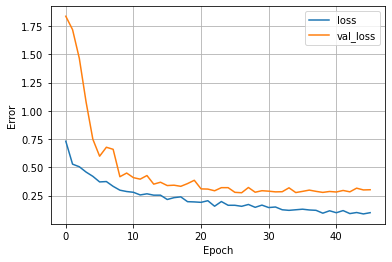

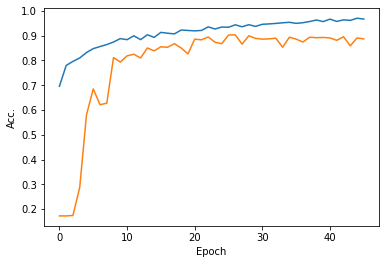

2022-03-31 19:55:11.074824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_28 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_29 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                      

2022-03-31 19:55:12.538789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.9842 - accuracy: 0.7547

2022-03-31 19:55:18.470736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.10158, saving model to ../models/2.0/version_2.0_best_model_fold-2.h5
98/98 [==============================] - 7s 69ms/step - loss: 0.9842 - accuracy: 0.7547 - val_loss: 1.1016 - val_accuracy: 0.1689
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5103 - accuracy: 0.8054
Epoch 00002: val_loss improved from 1.10158 to 0.63101, saving model to ../models/2.0/version_2.0_best_model_fold-2.h5
98/98 [==============================] - 7s 68ms/step - loss: 0.5099 - accuracy: 0.8056 - val_loss: 0.6310 - val_accuracy: 0.7249
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3930 - accuracy: 0.8328
Epoch 00003: val_loss improved from 0.63101 to 0.56624, saving model to ../models/2.0/version_2.0_best_model_fold-2.h5
98/98 [==============================] - 7s 71ms/step - loss: 0.3936 - accuracy: 0.8326 - val_loss: 0.5662 - val_accuracy: 0.7693
Epoch 4/10000
97/98 [============================>.] - ETA: 0s

Epoch 28/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1369 - accuracy: 0.9456
Epoch 00028: val_loss did not improve from 0.42239
98/98 [==============================] - 6s 63ms/step - loss: 0.1368 - accuracy: 0.9456 - val_loss: 0.4563 - val_accuracy: 0.7838
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9539
Epoch 00029: val_loss did not improve from 0.42239
98/98 [==============================] - 6s 64ms/step - loss: 0.1167 - accuracy: 0.9540 - val_loss: 0.4544 - val_accuracy: 0.7925
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9597
Epoch 00030: val_loss did not improve from 0.42239
98/98 [==============================] - 7s 67ms/step - loss: 0.1217 - accuracy: 0.9598 - val_loss: 0.4809 - val_accuracy: 0.7722
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.9594
Epoch 00031: val_loss did not improve from 0.42239
98/98 [=======

<Figure size 432x288 with 0 Axes>

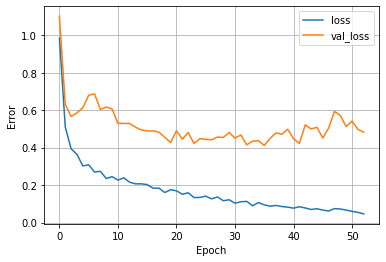

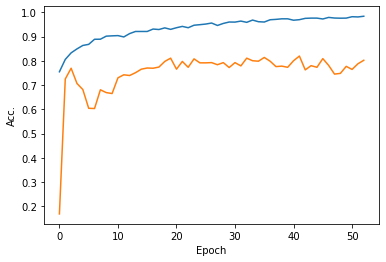

2022-03-31 20:00:58.009501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_32 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                      

2022-03-31 20:00:59.424535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.8904 - accuracy: 0.7412

2022-03-31 20:01:05.609602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.21999, saving model to ../models/2.0/version_2.0_best_model_fold-3.h5
98/98 [==============================] - 8s 74ms/step - loss: 0.8904 - accuracy: 0.7412 - val_loss: 1.2200 - val_accuracy: 0.1689
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5480 - accuracy: 0.8064
Epoch 00002: val_loss improved from 1.21999 to 0.66435, saving model to ../models/2.0/version_2.0_best_model_fold-3.h5
98/98 [==============================] - 7s 73ms/step - loss: 0.5475 - accuracy: 0.8066 - val_loss: 0.6643 - val_accuracy: 0.6091
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8322
Epoch 00003: val_loss improved from 0.66435 to 0.53262, saving model to ../models/2.0/version_2.0_best_model_fold-3.h5
98/98 [==============================] - 7s 71ms/step - loss: 0.4367 - accuracy: 0.8323 - val_loss: 0.5326 - val_accuracy: 0.8388
Epoch 4/10000
97/98 [============================>.] - ETA: 0s

Epoch 28/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9507
Epoch 00028: val_loss did not improve from 0.36069
98/98 [==============================] - 6s 65ms/step - loss: 0.1255 - accuracy: 0.9508 - val_loss: 0.3622 - val_accuracy: 0.8533
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1331 - accuracy: 0.9514
Epoch 00029: val_loss improved from 0.36069 to 0.34956, saving model to ../models/2.0/version_2.0_best_model_fold-3.h5
98/98 [==============================] - 7s 68ms/step - loss: 0.1335 - accuracy: 0.9511 - val_loss: 0.3496 - val_accuracy: 0.8668
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1236 - accuracy: 0.9575
Epoch 00030: val_loss did not improve from 0.34956
98/98 [==============================] - 6s 65ms/step - loss: 0.1235 - accuracy: 0.9575 - val_loss: 0.3511 - val_accuracy: 0.8639
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.96

<Figure size 432x288 with 0 Axes>

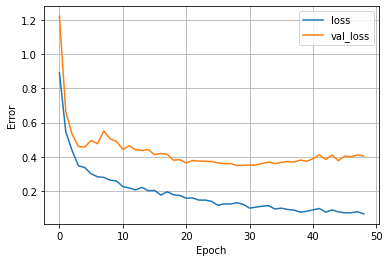

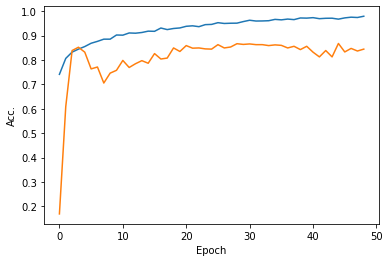

2022-03-31 20:06:18.709838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_36 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_37 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                      

2022-03-31 20:06:20.081740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.7374

2022-03-31 20:06:26.616161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.86360, saving model to ../models/2.0/version_2.0_best_model_fold-4.h5
98/98 [==============================] - 9s 83ms/step - loss: 0.9903 - accuracy: 0.7374 - val_loss: 0.8636 - val_accuracy: 0.1786
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5493 - accuracy: 0.7925
Epoch 00002: val_loss improved from 0.86360 to 0.47974, saving model to ../models/2.0/version_2.0_best_model_fold-4.h5
98/98 [==============================] - 7s 73ms/step - loss: 0.5489 - accuracy: 0.7927 - val_loss: 0.4797 - val_accuracy: 0.8263
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8328
Epoch 00003: val_loss improved from 0.47974 to 0.45374, saving model to ../models/2.0/version_2.0_best_model_fold-4.h5
98/98 [==============================] - 7s 73ms/step - loss: 0.4140 - accuracy: 0.8326 - val_loss: 0.4537 - val_accuracy: 0.8205
Epoch 4/10000
97/98 [============================>.] - ETA: 0s

<Figure size 432x288 with 0 Axes>

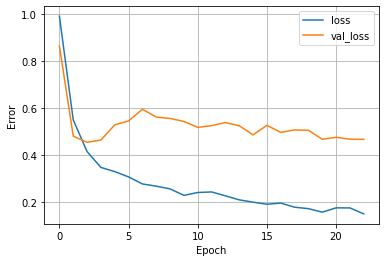

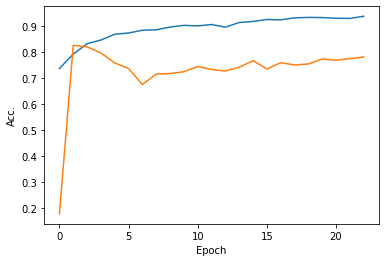

2022-03-31 20:08:50.689816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_40 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_41 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                     

2022-03-31 20:08:52.818809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.7432

2022-03-31 20:08:59.156756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.83043, saving model to ../models/2.0/version_2.0_best_model_fold-5.h5
98/98 [==============================] - 9s 80ms/step - loss: 0.9622 - accuracy: 0.7432 - val_loss: 0.8304 - val_accuracy: 0.1873
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.8102
Epoch 00002: val_loss improved from 0.83043 to 0.49001, saving model to ../models/2.0/version_2.0_best_model_fold-5.h5
98/98 [==============================] - 7s 74ms/step - loss: 0.5176 - accuracy: 0.8098 - val_loss: 0.4900 - val_accuracy: 0.8185
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4122 - accuracy: 0.8289
Epoch 00003: val_loss improved from 0.49001 to 0.44778, saving model to ../models/2.0/version_2.0_best_model_fold-5.h5
98/98 [==============================] - 7s 75ms/step - loss: 0.4120 - accuracy: 0.8285 - val_loss: 0.4478 - val_accuracy: 0.8185
Epoch 4/10000
97/98 [============================>.] - ETA: 0s

Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1330 - accuracy: 0.9523
Epoch 00029: val_loss did not improve from 0.39076
98/98 [==============================] - 7s 68ms/step - loss: 0.1328 - accuracy: 0.9524 - val_loss: 0.4024 - val_accuracy: 0.8205
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1158 - accuracy: 0.9533
Epoch 00030: val_loss did not improve from 0.39076
98/98 [==============================] - 6s 65ms/step - loss: 0.1158 - accuracy: 0.9530 - val_loss: 0.3994 - val_accuracy: 0.8301
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1137 - accuracy: 0.9607
Epoch 00031: val_loss did not improve from 0.39076
98/98 [==============================] - 6s 65ms/step - loss: 0.1136 - accuracy: 0.9607 - val_loss: 0.3978 - val_accuracy: 0.8311
Epoch 32/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1044 - accuracy: 0.9572
Epoch 00032: val_loss did not improve from 0.39076
98/98 [=======

<Figure size 432x288 with 0 Axes>

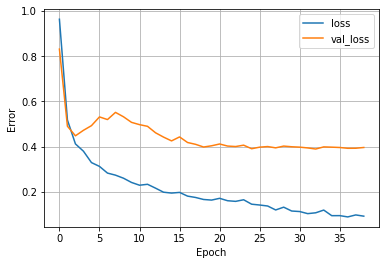

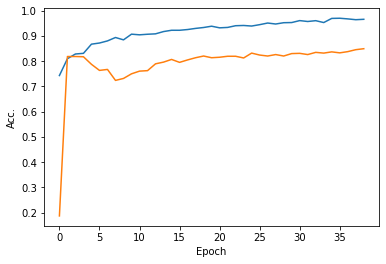

2022-03-31 20:13:12.978579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [19]:
train("2.0")

In [ ]:
test('cnn_for_5H_trial1.h5')